## Logistic Regression

#### Import all Libraries needed for the model 

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import pylab as pl

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve, auc

from sklearn import metrics

from sklearn.model_selection import train_test_split

Import the Open Food Dataset . First import only 10000 records . 

In [2]:
pd_1 = pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t',nrows = 10000 )


/Users/vingadgil/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd_null = pd_1[pd_1.product_name.isnull()]
#pd_null[['code','product_name','ingredients_text']].head()

,code,product_name,ingredients_text
1,0000000027205,NaN,NaN
10,0000007020254,NaN,NaN
23,0000069105241,NaN,NaN
28,0000140000083,NaN,NaN
29,00002523,NaN,NaN


In [3]:
print(len(pd_1[pd_1.ingredients_text.isnull()]))
print(len(pd_1))

5546
10000


Select only records from data which actually have ingredients i.e. ingredients_text has some values. We shall only be considering such records.

In [4]:
pd_1 = pd_1[pd_1.ingredients_text.notnull()]
len(pd_1)

4454

Out of 10000 records there are only 4454 records which has ingredients. For our sample , we only use 4454 records for modeling

In [5]:
# get col names
#col_names = pd_1.columns.values.tolist()
#col_names

Selecting only specific columns from the dataset which is required for the logisitic regresssion - Code, Product name,
Ingredients, Additives in the dataset and number of additives in each item.

In [6]:
pd_new = pd_1[['code' , 'product_name' , 'ingredients_text', 'additives','additives_n','main_category_en']]
pd_new = pd_new[pd_new.ingredients_text.notnull()]


#### Calculate Top 50 Ingredients from the Ingredients_text

Split all the ingredients_text by comma ','

In [9]:
# Calculate top 50 Ingredients -

# get counts by ingredient
# taken from http://stackoverflow.com/questions/12680754/split-pandas-dataframe-string-entry-to-separate-rows
df_ingredients_tmp = pd_new[['code' , 'ingredients_text']]

df_ingredients = df_ingredients_tmp.ingredients_text.str.split(',').tolist()
df_tmp = pd.DataFrame(df_ingredients,index=df_ingredients_tmp.code).stack() 
df_tmp = df_tmp.reset_index()[[0, 'code']] # var1 variable is currently labeled 0
df_tmp.columns = ['ingredients_text', 'code'] # renaming var1

# Get the count for each ingredients.
df1 = df_tmp['ingredients_text'].str.upper().value_counts()
df1.index


Index([' SEL', ' SALT', ' SUCRE', ' SUGAR', ' EAU', ' WATER', ' DEXTROSE',
       ' NIACIN', ' CITRIC ACID', ' SIROP DE GLUCOSE',
       ...
       ' CHOCOLAT AU LAIT AVEC DU MIEL (20%) (SUCRE', ' HARINA DE ARROZ',
       ' GOUSSE DE VANILLE EN POUDRE 0',
       ' NONFAT MILK SOY LECITHIN AN EMULSIFIER AND VANILLA)',
       'POITRINE DE PORC AVEC COUENNE', ' COSSE DE SORGHO',
       ' NITRITE DE SODIUM ; DEXTROSE', ' SAFFLOWER OIL)',
       ' MALTED BARLEY FLOUR)', ' 38% ROSETTE (VIANDE DE PORC'],
      dtype='object', length=17793)

In [10]:
df_tmp['ingredients_text'] = df_tmp['ingredients_text'].str.upper()

# group by each ingredient and count unique number of products ('code')
df_ingredients_ranks = pd.DataFrame(df_tmp.groupby('ingredients_text').code.nunique())
# rename col
df_ingredients_ranks.columns = ['num_products'] # renaming
# sort it
df_ingredients_ranks = df_ingredients_ranks.sort(['num_products'], ascending=[False])
# here is the top 50 ingredients
df_ingredients_top50 = df_ingredients_ranks.head(50)
df_ingredients_top50

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,num_products
ingredients_text,
SEL,701
SALT,658
SUCRE,590
SUGAR,462
EAU,429
WATER,280
DEXTROSE,264
NIACIN,183
CITRIC ACID,169


In [13]:
#df_ingredients_ranks.to_csv('50ingredients.csv')

In [12]:
#pd_new.head()

### Creating the Logistic Regression Model 

Plotting Additives_N field. In order to plot the additives , we have ignored all entries which are 0. Just plotting values which are above 0.

In [13]:
pd_additive = pd_new[pd_new.additives_n > 0]

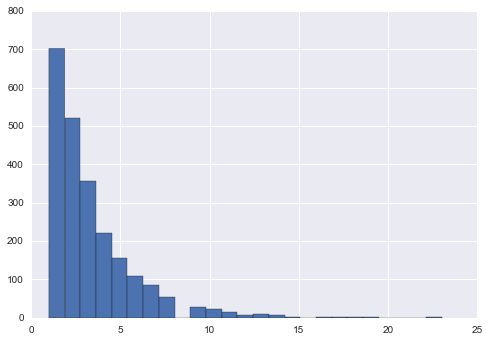

In [14]:
pd_additive.additives_n.hist(bins=25)

Since We would be using Additives_n column for Regression model we shall create a new column called'High Add' .


If Additives_n > 4 ,
     
   High Add = 1.
 
Else 

   High Add = 0.

In [15]:
pd_new['high_add'] = np.where(pd_new['additives_n']>4, '1', '0')

In [16]:
len(pd_new[pd_new['high_add'] == '1'])

505

Around 505 items out of 4454 records have more than 4 additives in ingredients. Around 12% records have high additives

##### Based on the Top 50 ingredients and checking the Top 20 Additives on Web , we create new dummy variables.
TOP 20 Additives that we search in the Ingredients are -

1. SALT
2. SUGAR
3. CHOCO / CHOCOLATE
4. DEXTROSE
5. CITRIC ACID
6. AROME
7. COCOA BUTTER
8. GLUCOSE
9. CORN SYRUP
10. WHEAT
11. CARBONATED WATER
12. PALM OIL
13. MONOSODIUM GLUTAMATE
14. YEAST
15. HYDROGENATED OIL
16. ARTIFICIAL COLORS
17. SODIUM NITRATE / SODIUM NITRITE
18. BHA
19. BHT
20. STARCH
21. ARTIFICAL SWEETNERS- Saccharin,Aspartame,Sucralose,Agave nectar,Bleached starch


Create new Columns to check if ingredients have additives. For each Additive we add another column if ingredients 
have that material

In [17]:
pd_new['ingredients_text'] = pd_new['ingredients_text'].str.upper()

In [18]:
def new_coumn(column_name,label):
    
    pattern = '|'.join(label)
    
    pd_new[column_name] = pd_new['ingredients_text'].str.contains(pattern)
    pd_new.column_name = pd_new.column_name.astype(int)
    
    return pd_new[column_name]

In [19]:
# Check if Ingredients have Wheat .

#pd_new['has_wheat'] = pd_new['ingredients_text'].str.match('Wheat|wheat',case = '1', na='0')

wheat = ['Wheat','wheat','Weizen','blé','trigo','WHEAT']
pattern = '|'.join(wheat)
pd_new['has_wheat'] = pd_new['ingredients_text'].str.contains(pattern)
pd_new.has_wheat = pd_new.has_wheat.astype(int)


# Check if Ingredients has Salt.

salt = ['Salt','SALT','SAL','SALZ','SEL']
pattern = '|'.join(salt)
pd_new['has_salt'] = pd_new['ingredients_text'].str.contains(pattern) 
pd_new.has_salt = pd_new.has_salt.astype(int)

# Check if Ingredients has Sugar

sugar = ['SUGAR','SUCRE','AZÚCAR','ZUCKER','Sugar']
sugar = '|'.join(sugar)
pd_new['has_sugar'] = pd_new['ingredients_text'].str.contains(sugar)
pd_new.has_sugar = pd_new.has_sugar.astype(int)

# Check if Ingredients has Chocolate .

chocolate = ['CHOCO','CHOCOLATE','CHOCOLAT','SCHOKOLADE','Chocolate']
chocolate = '|'.join(chocolate)
pd_new['has_choco'] = pd_new['ingredients_text'].str.contains(chocolate)
pd_new.has_choco = pd_new.has_choco.astype(int)

# Check if Ingredients has Milk

milk = ['MILK','LECHE','MILCHE','LAIT','Milk']
milk = '|'.join(milk)

pd_new['has_milk'] = pd_new['ingredients_text'].str.contains(milk)
pd_new.has_milk = pd_new.has_milk.astype(int)

# Check if Ingredients has Color

color = ['Color','COLOR','FARBE','COULEUR']
color = '|'.join(color)

pd_new['has_color'] = pd_new['ingredients_text'].str.contains(color)
pd_new.has_color = pd_new.has_color.astype(int)

# Check if Ingredients has MSG

msg = ['MSG','Msg','MONOSODIUM GLUTAMATE']
msg = '|'.join(msg)

pd_new['has_msg'] = pd_new['ingredients_text'].str.contains(msg)
pd_new.has_msg = pd_new.has_msg.astype(int)

# Check if Ingredients has YEAST

yeast = ['Yeast','YEAST','LEVURE','HEFE','LEVADURA']
yeast = '|'.join(yeast)

pd_new['has_yeast'] = pd_new['ingredients_text'].str.contains(yeast)
pd_new.has_yeast = pd_new.has_yeast.astype(int)

# Check if Ingredients has cocoa butter

cocoa = ['Cocoa Butter','COCOA BUTTER','COCOA','KAKAOBUTTER','LE BEURRE DE CACAO','CACAO','KAKAO']
cocoa = '|'.join(cocoa)

pd_new['has_cocoa'] = pd_new['ingredients_text'].str.contains(cocoa)
pd_new.has_cocoa = pd_new.has_cocoa.astype(int)

# Check if Ingredients has Palm Oil

palm = ['Palm Oil','PALM OIL','PALMÖL','HUILE DE PALME','ACEITE DE PALMA']
palm = '|'.join(palm)

pd_new['has_palm'] = pd_new['ingredients_text'].str.contains(palm)
pd_new.has_palm = pd_new.has_palm.astype(int)
    


In [20]:
# Additional Columns
# Check if Ingredients has Water

water = ['WATER','water','WASSER','AGUA','EAU']
water = '|'.join(water)

pd_new['has_water'] = pd_new['ingredients_text'].str.contains(water)
pd_new.has_water = pd_new.has_water.astype(int)

# Check if Ingredients has Garlic

garlic = ['Garlic','GARLIC','AIL','KNOBLAUCH','AJO']
garlic = '|'.join(garlic)

pd_new['has_garlic'] = pd_new['ingredients_text'].str.contains(garlic)
pd_new.has_garlic = pd_new.has_garlic.astype(int)

# Check if Ingredients has Flour

flour = ['Flour','FLOUR','MEHL','FARINE','HARINA']
flour = '|'.join(flour)

pd_new['has_flour'] = pd_new['ingredients_text'].str.contains(flour)
pd_new.has_flour = pd_new.has_flour.astype(int)

# Check if Ingredients has Ginger

ginger = ['Ginger','GINGER','GINGREMBRE','INGWER','JINGIBRE']
ginger = '|'.join(ginger)

pd_new['has_ginger'] = pd_new['ingredients_text'].str.contains(ginger)
pd_new.has_ginger = pd_new.has_ginger.astype(int)

# Check if Ingredients has honey

honey = ['Honey','HONEY','HONIG','MIEL']
honey = '|'.join(honey)

pd_new['has_honey'] = pd_new['ingredients_text'].str.contains(honey)
pd_new.has_honey = pd_new.has_honey.astype(int)

In [22]:
pd_new.head()

,code,product_name,ingredients_text,additives,additives_n,main_category_en,high_add,has_wheat,has_salt,has_sugar,...,has_msg,has_yeast,has_cocoa,has_palm,has_water,has_garlic,has_flour,has_ginger,has_honey,is_plant
5,0000000056434,diet lemonade by Sainsbury's,"CARBONATED WATER, ACID: CITRIC ACID; FLAVOURI...",[ carbonated-water -> en:carbonated-water ] ...,4.0,NaN,0,0,0,0,...,0,0,0,0,1,0,0,0,0,NaN
6,0000001071894,Flute,WHEAT,[ wheat -> en:wheat ],0.0,Plant-based foods and beverages,0,1,0,0,...,0,0,0,0,0,0,0,0,0,True
7,0000001471762,still Scottish water,WATER,[ water -> en:water ],0.0,NaN,0,0,0,0,...,0,0,0,0,1,0,0,0,0,NaN
8,0000001798180,Fairtrade Ground Cinnamon,CINNAMON,[ cinnamon -> en:cinnamon ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9,0000005200016,lentilles vertes,LENTILLES VERTES,[ lentilles-vertes -> fr:lentilles-vertes ] ...,0.0,Plant-based foods and beverages,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True


In [ ]:
Create Dummy Variables for each of the Categories. The Top 20 Categories are -


Plant-based foods and beverages                     
Sugary snacks                                        
Beverages                                            
Dairies                                              
Groceries                                            
Meats                                                
Fresh foods                                          
Meals                                                
Salty snacks                                         
Canned foods                                         
Frozen foods                                         
Fruit juices                                         
Breakfasts                                            
Seafood                                               
Desserts                                              
          

### Create Additional Dummy Columns in dataframe for TOP 20 CATEGORIES

In [29]:
# Create columns on Categories 
pd_new['is_plant'] =  np.where(pd_new['main_category_en'] == 'Plant-based foods and beverages', '1', '0')
pd_new.is_plant = pd_new.is_plant.astype(int)

pd_new['is_bev'] = np.where(pd_new['main_category_en'] == 'Beverages','1','0')
pd_new.is_bev = pd_new.is_bev.astype(int)

pd_new['is_sugar'] = np.where(pd_new['main_category_en'] == 'Sugary snacks','1','0')
pd_new.is_sugar = pd_new.is_sugar.astype(int)

pd_new['is_salt'] = np.where(pd_new['main_category_en'] == 'Salty snacks','1','0')
pd_new.is_salt = pd_new.is_salt.astype(int)

pd_new['is_dairy'] = np.where(pd_new['main_category_en'] == 'Dairies','1','0')
pd_new.is_dairy = pd_new.is_dairy.astype(int)

pd_new['is_meat'] = np.where(pd_new['main_category_en'] == 'Meats|Seafood','1','0')
pd_new.is_meat = pd_new.is_meat.astype(int)

pd_new['is_fresh'] = np.where(pd_new['main_category_en'] == 'Fresh foods','1','0')
pd_new.is_fresh = pd_new.is_fresh.astype(int)

pd_new['is_break'] = np.where(pd_new['main_category_en'] == 'Breakfasts','1','0')
pd_new.is_break = pd_new.is_break.astype(int)

pd_new['is_frozen'] = np.where(pd_new['main_category_en'] == 'Frozen foods','1','0')
pd_new.is_frozen = pd_new.is_frozen.astype(int)

pd_new['is_juices'] = np.where(pd_new['main_category_en'] == 'Fruit Juices','1','0')
pd_new.is_juices = pd_new.is_juices.astype(int)



In [26]:
# manually add the intercept
pd_new['intercept'] = 1.0

In [27]:
pd_new['high_add'] = pd_new['high_add'].astype(int)

In [30]:
#pd_new.to_csv('abcd.csv')
pd_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4454 entries, 5 to 9999
Data columns (total 33 columns):
code                4454 non-null object
product_name        4417 non-null object
ingredients_text    4454 non-null object
additives           3987 non-null object
additives_n         4452 non-null float64
main_category_en    4192 non-null object
high_add            4454 non-null int64
has_wheat           4454 non-null int64
has_salt            4454 non-null int64
has_sugar           4454 non-null int64
has_choco           4454 non-null int64
has_milk            4454 non-null int64
has_color           4454 non-null int64
has_msg             4454 non-null int64
has_yeast           4454 non-null int64
has_cocoa           4454 non-null int64
has_palm            4454 non-null int64
has_water           4454 non-null int64
has_garlic          4454 non-null int64
has_flour           4454 non-null int64
has_ginger          4454 non-null int64
has_honey           4454 non-null int64
is_pla

In [31]:
pd_new

,code,product_name,ingredients_text,additives,additives_n,main_category_en,high_add,has_wheat,has_salt,has_sugar,...,is_bev,is_salt,is_dairy,is_meat,is_fresh,is_break,is_frozen,intercept,is_sugar,is_juices
5,0000000056434,diet lemonade by Sainsbury's,"CARBONATED WATER, ACID: CITRIC ACID; FLAVOURI...",[ carbonated-water -> en:carbonated-water ] ...,4.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0,0
6,0000001071894,Flute,WHEAT,[ wheat -> en:wheat ],0.0,Plant-based foods and beverages,0,1,0,0,...,0,0,0,0,0,0,0,1.0,0,0
7,0000001471762,still Scottish water,WATER,[ water -> en:water ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0,0
8,0000001798180,Fairtrade Ground Cinnamon,CINNAMON,[ cinnamon -> en:cinnamon ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0,0
9,0000005200016,lentilles vertes,LENTILLES VERTES,[ lentilles-vertes -> fr:lentilles-vertes ] ...,0.0,Plant-based foods and beverages,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0,0
11,0000007730009,Biscuits sablés fourrage au cacao,"SUCRE, FARINE DE _BLÉ_, GRAISSE ET HUILES VÉGÉ...",[ sucre -> fr:sucre ] [ farine-de-ble -> fr...,3.0,Sugary snacks,0,0,1,1,...,0,0,0,0,0,0,0,1.0,1,0
12,0000010090206,Thé de Noël aromatisé orange-cannelle,"THÉ NOIR DE CHINE, ZESTES D'ORANGES 7,5 %, ARÔ...",[ the-noir-de-chine -> fr:the-noir-de-chine ...,0.0,Beverages,0,0,0,0,...,1,0,0,0,0,0,0,1.0,0,0
13,0000010127735,Sirops pour ganache macarons,"SIROP SAVEUR PISTACHE 5 CL : SIROP 99,16 % (SU...",[ sirop-saveur-pistache-5-cl -> fr:sirop-save...,4.0,Syrups,0,0,0,1,...,0,0,0,0,0,0,0,1.0,0,0
14,0000012345878,เล็บมือนาง (ตีนไก่ ),ตีนไก่,[ ตีนไก่ -> en:ตีนไก่ ],0.0,Chicken-feet,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0,0
16,0000024089517,hrenovka za pečenje na žaru hofer,77,[ 77 -> en:77 ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0,0


LOGISTIC REGRESSION MODEL

In [32]:
# Creating the model with 7 dependant columns

train_cols = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm','intercept']
#               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey',

logit = sm.Logit(pd_new['high_add'], pd_new[train_cols])

# fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.306835
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4446
Method:                           MLE   Df Model:                            7
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.1321
Time:                        01:29:47   Log-Likelihood:                -1366.6
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                 9.131e-86
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.7141      0.143      5.005      0.000         0.434     0.994
has_salt       0.8491      0.118      7.204      0.000         0.618     1.080
has_sugar      0.7972      0.112      7.092      0.000         0.577     1.018
has_choco      0.4492      0.251      1.792      0.073        -0.042     0.941
has_milk       0.8521      0.107      7.935      0.000         0.642     1.063
has_cocoa     -0.5877      0.222     -2.652      0.008        -1.022    -0.153
has_palm       0.8585      0.167      5.131      0.000         0.531     1.186
intercept     -3.4025      0.111    -30.642      0.000        -3.620    -3.185
==============================================================================
"""

In [33]:
# Find the actual values of ones and zeros in each dummy column
#print(pd_new.has_wheat.sum())
#print(pd_new.has_salt.sum())
#print(pd_new.has_palm.sum())
#print(pd_new.has_sugar.sum())
#print(pd_new.has_cocoa.sum())
#print(pd_new.has_milk.sum())
#print(pd_new.has_color.sum())

In [34]:
# look at the confidence interval of each coeffecient
result.conf_int()

,0,1
has_wheat,0.434454,0.993810
has_salt,0.618117,1.080173
has_sugar,0.576910,1.017536
has_choco,-0.042165,0.940580
has_milk,0.641628,1.062586
has_cocoa,-1.021989,-0.153354
has_palm,0.530542,1.186377
intercept,-3.620184,-3.184909


In [35]:
np.exp(result.params)

has_wheat    2.042413
has_salt     2.337647
has_sugar    2.219369
has_choco    1.567070
has_milk     2.344581
has_cocoa    0.555620
has_palm     2.359524
intercept    0.033288
dtype: float64

In [36]:
# Predict Y using the logit function.
pd_new['ypred'] = result.predict(pd_new[train_cols])


In [37]:
pd_new[['high_add','ypred']].head()

,high_add,ypred
5,0,0.032216
6,0,0.063660
7,0,0.032216
8,0,0.032216
9,0,0.032216


Converting the ypred probability into value of 0 and 1

In [38]:
pd_new['ypred_class'] = np.where(pd_new['ypred']>0.12, '1', '0')
pd_new['ypred_class'] = pd_new['ypred_class'].astype(int)
pd_new[['high_add','ypred_class']].head(5)

,high_add,ypred_class
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [39]:
# Create confusin matrix from Scikit
matrix = confusion_matrix(pd_new['high_add'], pd_new['ypred_class'])
print(matrix)


[[2699 1250]
 [ 144  361]]


In [41]:
# Using Pandas confusion create the confusion matrix

from pandas_confusion import ConfusionMatrix

confusion_matrix = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class'])
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted     0     1  __all__
Actual                        
0          2699  1250     3949
1           144   361      505
__all__    2843  1611     4454


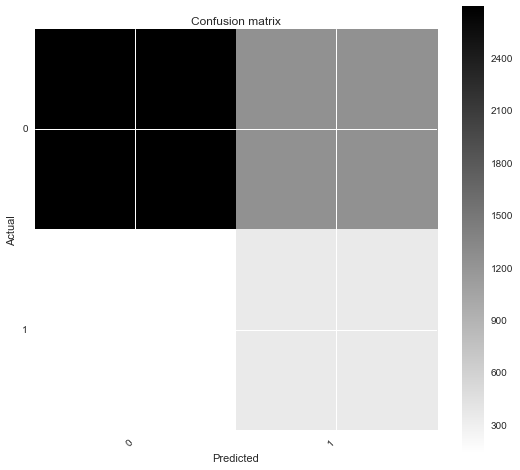

In [42]:
confusion_matrix.plot()
plt.show()

In [44]:
confusion_matrix.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          2699  1250     3949
1           144   361      505
__all__    2843  1611     4454


Overall Statistics:

Accuracy: 0.687022900763
95% CI: (0.67317322857085415, 0.70062694192579322)
No Information Rate: ToDo
P-Value [Acc > NIR]: 4.45220001629e-12
Kappa: 0.203740557616
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                  4454       4454
P: Condition positive                       3949        505
N: Condition negative                        505       3949
Test outcome positive                       2843       1611
Test outcome negative                       1611       2843
TP: True Positive                           2699        361
TN: True Negative                            361       2699
FP: False Positive                           144       1250
FN: False Negative                          1250  

In [45]:
# Another way of calculating accuracy score
#X.mean()
#Ypred = (result.predict(pd_new[train_cols]) >= 0.12)
#true_pos = Ypred * X
#true_neg = (1 - Ypred) * (1 - X)
#acc = (sum(true_pos) + sum(true_neg))/len(X)
#acc

In [46]:
# Create ROC curve for Baseline model
false_positive_rate, true_positive_rate, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred'])
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


0.75054268658063572

In [47]:
#New model - Create a new dataframe with random values in 7 columns and cross check with above logit model

pd_random = pd_new[['code','product_name','high_add']]
pd_size = len(pd_random)

pd_random['col1'] = np.random.randint(2, size=pd_size)
pd_random['col2'] = np.random.randint(2, size=pd_size)
pd_random['col3'] = np.random.randint(2, size=pd_size)
pd_random['col4'] = np.random.randint(2, size=pd_size)
pd_random['col5'] = np.random.randint(2, size=pd_size)
pd_random['col6'] = np.random.randint(2, size=pd_size)
pd_random['col7'] = np.random.randint(2, size=pd_size)


/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [48]:
pd_random['intercept'] = 1.0
pd_random.head()

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,code,product_name,high_add,col1,col2,col3,col4,col5,col6,col7,intercept
5,0000000056434,diet lemonade by Sainsbury's,0,1,0,0,0,1,1,1,1.0
6,0000001071894,Flute,0,1,1,0,1,0,1,1,1.0
7,0000001471762,still Scottish water,0,1,0,0,0,1,1,1,1.0
8,0000001798180,Fairtrade Ground Cinnamon,0,0,0,1,0,0,1,1,1.0
9,0000005200016,lentilles vertes,0,0,0,0,1,1,0,0,1.0


In [49]:
train_cols_r = [ 'col1' , 'col2' , 'col3', 'col4' ,'col5','col6','col7','intercept']
logit_random = sm.Logit(pd_random['high_add'], pd_random[train_cols_r])

# fit the model
result_random = logit_random.fit()
result_random.summary()

Optimization terminated successfully.
         Current function value: 0.353118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4446
Method:                           MLE   Df Model:                            7
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                0.001156
Time:                        01:45:36   Log-Likelihood:                -1572.8
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                    0.8200
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
col1           0.1273      0.095      1.345      0.179        -0.058     0.313
col2           0.0570      0.095      0.602      0.547        -0.129     0.243
col3          -0.0323      0.095     -0.341      0.733        -0.218     0.153
col4           0.0025      0.095      0.026      0.979        -0.183     0.188
col5           0.0698      0.095      0.738      0.461        -0.116     0.255
col6           0.0670      0.095      0.708      0.479        -0.118     0.252
col7          -0.0524      0.095     -0.553      0.580        -0.238     0.133
intercept     -2.1764      0.136    -16.010      0.000        -2.443    -1.910
==============================================================================
"""

In [50]:
# Predict Y using the logit function.
pd_random['ypred'] = result.predict(pd_random[train_cols_r])

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [51]:
pd_random['ypred_class'] = np.where(pd_random['ypred']>0.12, '1', '0')
pd_random['ypred_class'] = pd_random['ypred_class'].astype(int)

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [52]:
from pandas_confusion import ConfusionMatrix

matrix_random = ConfusionMatrix(pd_random['high_add'], pd_random['ypred_class'])
print("Confusion matrix:\n%s" % matrix_random)


Confusion matrix:
Predicted     0     1  __all__
Actual                        
0          1063  2886     3949
1           131   374      505
__all__    1194  3260     4454


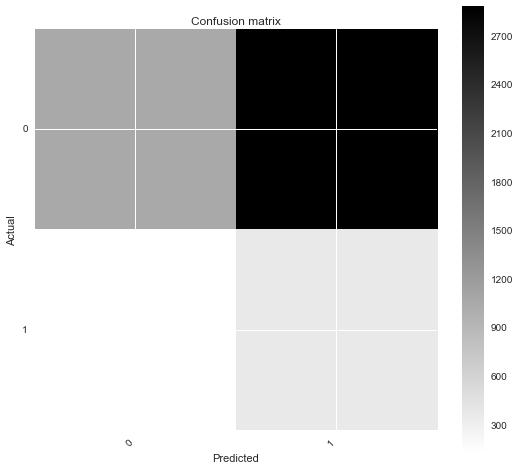

In [53]:
matrix_random.plot()
plt.show()

In [55]:
# Calculate the accuracy score
matrix_random.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          1063  2886     3949
1           131   374      505
__all__    1194  3260     4454


Overall Statistics:

Accuracy: 0.322631342613
95% CI: (0.30891006780986985, 0.33658554863326617)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.00289328775347
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                         0           1
Population                                   4454        4454
P: Condition positive                        3949         505
N: Condition negative                         505        3949
Test outcome positive                        1194        3260
Test outcome negative                        3260        1194
TP: True Positive                            1063         374
TN: True Negative                             374        1063
FP: False Positive                            131        2886
FN: False Negative                          

In [56]:
# ROC values for Random Model
false_positive_ran, true_positive_ran, thresholds_ran = roc_curve(pd_random['high_add'], pd_random['ypred'])
roc_auc_ran = auc(false_positive_ran, true_positive_ran)
roc_auc_ran

0.50585860814493699

In [57]:
print(metrics.classification_report(pd_new['high_add'], pd_new['ypred_class']))

             precision    recall  f1-score   support

          0       0.95      0.68      0.79      3949
          1       0.22      0.71      0.34       505

avg / total       0.87      0.69      0.74      4454



#### Create Logistic Regression with 12 Dependant Variable

In [60]:
train_cols_12 = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','intercept']

logit_12 = sm.Logit(pd_new['high_add'], pd_new[train_cols_12])

# fit the model
result_12 = logit_12.fit()
result_12.summary()

Optimization terminated successfully.
         Current function value: 0.291784
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4441
Method:                           MLE   Df Model:                           12
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.1746
Time:                        02:08:10   Log-Likelihood:                -1299.6
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                4.930e-110
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.5492      0.163      3.370      0.001         0.230     0.869
has_salt       0.4594      0.131      3.505      0.000         0.203     0.716
has_sugar      0.5677      0.118      4.818      0.000         0.337     0.799
has_choco      0.2472      0.262      0.945      0.345        -0.266     0.760
has_milk       0.8951      0.112      7.985      0.000         0.675     1.115
has_cocoa     -0.2960      0.234     -1.263      0.207        -0.756     0.163
has_palm       0.9538      0.178      5.365      0.000         0.605     1.302
has_water      1.0891      0.111      9.793      0.000         0.871     1.307
has_garlic    -0.2728      0.163     -1.671      0.095        -0.593     0.047
has_flour      0.6211      0.133      4.684      0.000         0.361     0.881
has_ginger    -0.0389      0.317     -0.123      0.902        -0.660     0.582
has_honey     -0.5302      0.310     -1.711      0.087        -1.138     0.077
intercept     -3.6988      0.122    -30.410      0.000        -3.937    -3.460
==============================================================================
"""

In [61]:
result_12.conf_int()

,0,1
has_wheat,0.229763,0.868601
has_salt,0.202514,0.716287
has_sugar,0.336761,0.798678
has_choco,-0.265737,0.760091
has_milk,0.675382,1.114768
has_cocoa,-0.755525,0.163443
has_palm,0.605317,1.302232
has_water,0.871106,1.307058
has_garlic,-0.592678,0.047123
has_flour,0.361219,0.880945


In [62]:
np.exp(result_12.params)

has_wheat     1.731836
has_salt      1.583124
has_sugar     1.764239
has_choco     1.280406
has_milk      2.447519
has_cocoa     0.743757
has_palm      2.595489
has_water     2.971545
has_garlic    0.761262
has_flour     1.860940
has_ginger    0.961875
has_honey     0.588464
intercept     0.024753
dtype: float64

In [64]:
# Predict Y using the logit function.
pd_new['ypred_12'] = result_12.predict(pd_new[train_cols_12])

pd_new['ypred_class_12'] = np.where(pd_new['ypred_12']>0.12, '1', '0')
pd_new['ypred_class_12'] = pd_new['ypred_class_12'].astype(int)


In [65]:
confusion_matrix_12 = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class_12'])
print("Confusion matrix:\n%s" % confusion_matrix_12)

Confusion matrix:
Predicted     0     1  __all__
Actual                        
0          3121   828     3949
1           168   337      505
__all__    3289  1165     4454


In [66]:
confusion_matrix_12.print_stats()


Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          3121   828     3949
1           168   337      505
__all__    3289  1165     4454


Overall Statistics:

Accuracy: 0.77638078132
95% CI: (0.76385270352273649, 0.78854542877754974)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.62514302925e-09
Kappa: 0.29151756839
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                  4454       4454
P: Condition positive                       3949        505
N: Condition negative                        505       3949
Test outcome positive                       3289       1165
Test outcome negative                       1165       3289
TP: True Positive                           3121        337
TN: True Negative                            337       3121
FP: False Positive                           168        828
FN: False Negative                           828    

In [67]:
# Create ROC curve for 12 model
false_positive_rate_12, true_positive_rate_12, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred_12'])
roc_auc_12 = auc(false_positive_rate_12, true_positive_rate_12)
roc_auc_12

0.79125333146127974

#### Create Logitistic Regression with Ingredients and Category Dependant Variable

In [83]:
train_cols_20 = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','intercept']

#'is_frozen' ,'is_break' ,'is_dairy', 'is_fresh' ,'is_meat'

logit_20 = sm.Logit(pd_new['high_add'], pd_new[train_cols_20])

# fit the model
result_20 = logit_20.fit()
result_20.summary()

Optimization terminated successfully.
         Current function value: 0.287132
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4433
Method:                           MLE   Df Model:                           20
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.1878
Time:                        02:30:18   Log-Likelihood:                -1278.9
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                1.825e-112
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.5827      0.168      3.464      0.001         0.253     0.912
has_salt       0.3723      0.141      2.634      0.008         0.095     0.649
has_sugar      0.4756      0.121      3.922      0.000         0.238     0.713
has_choco      0.1431      0.261      0.548      0.584        -0.369     0.655
has_milk       0.8027      0.120      6.687      0.000         0.567     1.038
has_cocoa     -0.5811      0.245     -2.375      0.018        -1.061    -0.102
has_palm       0.9487      0.181      5.243      0.000         0.594     1.303
has_water      1.1756      0.121      9.715      0.000         0.938     1.413
has_garlic    -0.1770      0.166     -1.069      0.285        -0.502     0.148
has_flour      0.6421      0.141      4.556      0.000         0.366     0.918
has_ginger    -0.2097      0.328     -0.640      0.522        -0.852     0.433
has_honey     -0.4887      0.314     -1.554      0.120        -1.105     0.128
is_plant      -0.7324      0.174     -4.203      0.000        -1.074    -0.391
is_bev        -0.2957      0.233     -1.272      0.204        -0.751     0.160
is_sugar       0.5346      0.180      2.975      0.003         0.182     0.887
is_salt       -0.0245      0.333     -0.074      0.941        -0.677     0.628
is_frozen     -0.8833      0.442     -1.999      0.046        -1.749    -0.017
is_break       0.3012      0.428      0.704      0.481        -0.537     1.139
is_dairy      -0.1105      0.238     -0.463      0.643        -0.578     0.357
is_fresh       0.0597      0.276      0.216      0.829        -0.481     0.600
intercept     -3.5088      0.144    -24.354      0.000        -3.791    -3.226
==============================================================================
"""

In [84]:
result_20.conf_int()

,0,1
has_wheat,0.253020,0.912417
has_salt,0.095318,0.649277
has_sugar,0.237938,0.713354
has_choco,-0.368682,0.654917
has_milk,0.567461,1.038025
has_cocoa,-1.060728,-0.101528
has_palm,0.594078,1.303353
has_water,0.938459,1.412801
has_garlic,-0.501608,0.147577
has_flour,0.365864,0.918319


In [85]:
np.exp(result_20.params)


has_wheat     1.790901
has_salt      1.451064
has_sugar     1.609053
has_choco     1.153865
has_milk      2.231654
has_cocoa     0.559267
has_palm      2.582391
has_water     3.240182
has_garlic    0.837767
has_flour     1.900451
has_ginger    0.810818
has_honey     0.613428
is_plant      0.480748
is_bev        0.744024
is_sugar      1.706830
is_salt       0.975789
is_frozen     0.413415
is_break      1.351443
is_dairy      0.895376
is_fresh      1.061469
intercept     0.029933
dtype: float64

In [86]:
# Predict Y using the logit function.
pd_new['ypred_20'] = result_20.predict(pd_new[train_cols_20])

pd_new['ypred_class_20'] = np.where(pd_new['ypred_20']>0.12, '1', '0')
pd_new['ypred_class_20'] = pd_new['ypred_class_20'].astype(int)

In [87]:
confusion_matrix_20 = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class_20'])
print("Confusion matrix:\n%s" % confusion_matrix_20)


Confusion matrix:
Predicted     0     1  __all__
Actual                        
0          2992   957     3949
1           141   364      505
__all__    3133  1321     4454


In [88]:
confusion_matrix_20.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          2992   957     3949
1           141   364      505
__all__    3133  1321     4454


Overall Statistics:

Accuracy: 0.753480017961
95% CI: (0.74054692050475879, 0.76607993050642931)
No Information Rate: ToDo
P-Value [Acc > NIR]: 5.49273631902e-14
Kappa: 0.280682426913
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                  4454       4454
P: Condition positive                       3949        505
N: Condition negative                        505       3949
Test outcome positive                       3133       1321
Test outcome negative                       1321       3133
TP: True Positive                           2992        364
TN: True Negative                            364       2992
FP: False Positive                           141        957
FN: False Negative                           957  

In [89]:
# Create ROC curve for  model with 20 dependant variables
false_positive_rate_20, true_positive_rate_20, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred_20'])
roc_auc_20 = auc(false_positive_rate_20, true_positive_rate_20)
roc_auc_20

0.8082016001043002

#### Plot all ROC curve together.

1. Model with 7 dependant variable
2. Random Model with 7 dependant variable
3. Model with 12 dependant variable
3. Model with 20 dependant variable

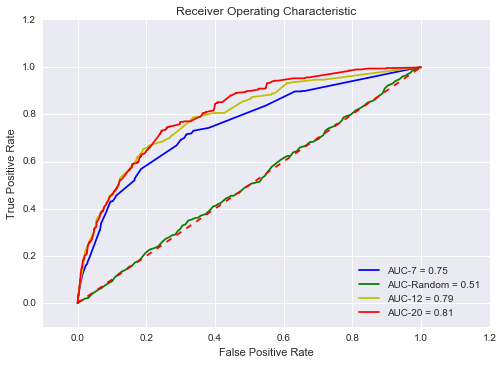

In [93]:
# Plot the actual ROC curve -
# Plot the curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC-7 = %0.2f'% roc_auc)
plt.plot(false_positive_ran, true_positive_ran, 'g',
label='AUC-Random = %0.2f'% roc_auc_ran)
plt.plot(false_positive_rate_12, true_positive_rate_12, 'y',
label='AUC-12 = %0.2f'% roc_auc_12)
plt.plot(false_positive_rate_20, true_positive_rate_20, 'r',
label='AUC-20 = %0.2f'% roc_auc_20)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We have generated model with 10,000 records. Now generate the new model with All entries in file. We then divide the file into training data and test data.

## Real-time full data

In [94]:
# Read the entire csv file into dataframe
main_data = pd.read_csv('en_openfoodfacts_Nov.csv', sep='\t' )

/Users/vingadgil/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,3,5,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [95]:
main_data.shape

(107343, 159)

In [ ]:
#train, test = train_test_split(pd_new, test_size = 0.3)
#len(train)
#len(test)

In [114]:
main_new = main_data[['code' , 'product_name' , 'ingredients_text', 'additives','additives_n','main_category_en']]
main_new = main_new[main_new.ingredients_text.notnull()]

In [117]:
len(main_new)

62266

Out of 107343 records we shall consider only 62266 records. Percantage of data used -

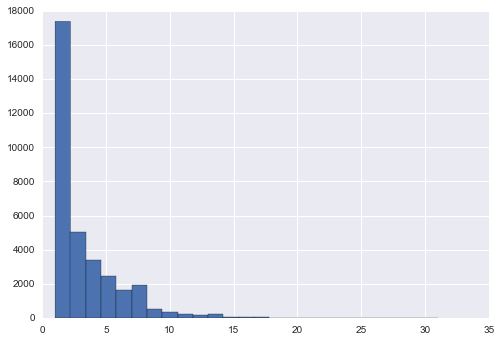

In [118]:
main_additive = main_new[main_new.additives_n > 0]

main_additive.additives_n.hist(bins=25)

In [119]:
main_new['high_add'] = np.where(main_new['additives_n']>4, '1', '0')

len(main_new[main_new['high_add'] == '1'])


7535

In [120]:
main_new.loc['ingredients_text'] = main_new['ingredients_text'].str.upper()

In [121]:
main_new = main_new[main_new.ingredients_text.notnull()]

In [122]:
# Check if Ingredients have Wheat .

#pd_new['has_wheat'] = pd_new['ingredients_text'].str.match('Wheat|wheat',case = '1', na='0')

wheat = ['Wheat','wheat','Weizen','blé','trigo','WHEAT']
pattern = '|'.join(wheat)
main_new['has_wheat'] = main_new['ingredients_text'].str.contains(pattern)
main_new.has_wheat = main_new.has_wheat.astype(int)


# Check if Ingredients has Salt.

salt = ['Salt','SALT','SAL','SALZ','SEL']
pattern = '|'.join(salt)
main_new['has_salt'] = main_new['ingredients_text'].str.contains(pattern) 
main_new.has_salt = main_new.has_salt.astype(int)

# Check if Ingredients has Sugar

sugar = ['SUGAR','SUCRE','AZÚCAR','ZUCKER','Sugar']
sugar = '|'.join(sugar)
main_new['has_sugar'] = main_new['ingredients_text'].str.contains(sugar)
main_new.has_sugar = main_new.has_sugar.astype(int)

# Check if Ingredients has Chocolate .

chocolate = ['CHOCO','CHOCOLATE','CHOCOLAT','SCHOKOLADE','Chocolate']
chocolate = '|'.join(chocolate)
main_new['has_choco'] = main_new['ingredients_text'].str.contains(chocolate)
main_new.has_choco = main_new.has_choco.astype(int)

# Check if Ingredients has Milk

milk = ['MILK','LECHE','MILCHE','LAIT','Milk']
milk = '|'.join(milk)

main_new['has_milk'] = main_new['ingredients_text'].str.contains(milk)
main_new.has_milk = main_new.has_milk.astype(int)

# Check if Ingredients has Color

color = ['Color','COLOR','FARBE','COULEUR']
color = '|'.join(color)

main_new['has_color'] = main_new['ingredients_text'].str.contains(color)
main_new.has_color = main_new.has_color.astype(int)

# Check if Ingredients has MSG

msg = ['MSG','Msg','MONOSODIUM GLUTAMATE']
msg = '|'.join(msg)

main_new['has_msg'] = main_new['ingredients_text'].str.contains(msg)
main_new.has_msg = main_new.has_msg.astype(int)

# Check if Ingredients has YEAST

yeast = ['Yeast','YEAST','LEVURE','HEFE','LEVADURA']
yeast = '|'.join(yeast)

main_new['has_yeast'] = main_new['ingredients_text'].str.contains(yeast)
main_new.has_yeast = main_new.has_yeast.astype(int)

# Check if Ingredients has cocoa butter

cocoa = ['Cocoa Butter','COCOA BUTTER','COCOA','KAKAOBUTTER','LE BEURRE DE CACAO','CACAO','KAKAO']
cocoa = '|'.join(cocoa)

main_new['has_cocoa'] = main_new['ingredients_text'].str.contains(cocoa)
main_new.has_cocoa = main_new.has_cocoa.astype(int)

# Check if Ingredients has Palm Oil

palm = ['Palm Oil','PALM OIL','PALMÖL','HUILE DE PALME','ACEITE DE PALMA']
palm = '|'.join(palm)

main_new['has_palm'] = main_new['ingredients_text'].str.contains(palm)
main_new.has_palm = main_new.has_palm.astype(int)


In [123]:
# Check if Ingredients has Water

water = ['WATER','water','WASSER','AGUA','EAU']
water = '|'.join(water)

main_new['has_water'] = main_new['ingredients_text'].str.contains(water)
main_new.has_water = main_new.has_water.astype(int)

# Check if Ingredients has Garlic

garlic = ['Garlic','GARLIC','AIL','KNOBLAUCH','AJO']
garlic = '|'.join(garlic)

main_new['has_garlic'] = main_new['ingredients_text'].str.contains(garlic)
main_new.has_garlic = main_new.has_garlic.astype(int)

# Check if Ingredients has Flour

flour = ['Flour','FLOUR','MEHL','FARINE','HARINA']
flour = '|'.join(flour)

main_new['has_flour'] = main_new['ingredients_text'].str.contains(flour)
main_new.has_flour = main_new.has_flour.astype(int)

# Check if Ingredients has Ginger

ginger = ['Ginger','GINGER','GINGREMBRE','INGWER','JINGIBRE']
ginger = '|'.join(ginger)

main_new['has_ginger'] = main_new['ingredients_text'].str.contains(ginger)
main_new.has_ginger = main_new.has_ginger.astype(int)

# Check if Ingredients has honey

honey = ['Honey','HONEY','HONIG','MIEL']
honey = '|'.join(honey)

main_new['has_honey'] = main_new['ingredients_text'].str.contains(honey)
main_new.has_honey = main_new.has_honey.astype(int)

In [124]:
# Create columns on Categories 
main_new['is_plant'] =  np.where(main_new['main_category_en'] == 'Plant-based foods and beverages', '1', '0')
main_new.is_plant = main_new.is_plant.astype(int)

main_new['is_bev'] = np.where(main_new['main_category_en'] == 'Beverages','1','0')
main_new.is_bev = main_new.is_bev.astype(int)

main_new['is_sugar'] = np.where(main_new['main_category_en'] == 'Sugary snacks','1','0')
main_new.is_sugar = main_new.is_sugar.astype(int)

main_new['is_salt'] = np.where(main_new['main_category_en'] == 'Salty snacks','1','0')
main_new.is_salt = main_new.is_salt.astype(int)

main_new['is_dairy'] = np.where(main_new['main_category_en'] == 'Dairies','1','0')
main_new.is_dairy = main_new.is_dairy.astype(int)

main_new['is_meat'] = np.where(main_new['main_category_en'] == 'Meats|Seafood','1','0')
main_new.is_meat = main_new.is_meat.astype(int)

main_new['is_fresh'] = np.where(main_new['main_category_en'] == 'Fresh foods','1','0')
main_new.is_fresh = main_new.is_fresh.astype(int)

main_new['is_break'] = np.where(main_new['main_category_en'] == 'Breakfasts','1','0')
main_new.is_break = main_new.is_break.astype(int)

main_new['is_frozen'] = np.where(main_new['main_category_en'] == 'Frozen foods','1','0')
main_new.is_frozen = main_new.is_frozen.astype(int)

main_new['is_juices'] = np.where(main_new['main_category_en'] == 'Fruit Juices','1','0')
main_new.is_juices = main_new.is_juices.astype(int)



In [125]:
# manually add the intercept
main_new['intercept'] = 1.0
main_new['high_add'] = main_new['high_add'].astype(int)


In [127]:
main_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62266 entries, 2 to 107340
Data columns (total 33 columns):
code                62244 non-null object
product_name        61980 non-null object
ingredients_text    62266 non-null object
additives           61742 non-null object
additives_n         62230 non-null float64
main_category_en    60262 non-null object
high_add            62266 non-null int64
has_wheat           62266 non-null int64
has_salt            62266 non-null int64
has_sugar           62266 non-null int64
has_choco           62266 non-null int64
has_milk            62266 non-null int64
has_color           62266 non-null int64
has_msg             62266 non-null int64
has_yeast           62266 non-null int64
has_cocoa           62266 non-null int64
has_palm            62266 non-null int64
has_water           62266 non-null int64
has_garlic          62266 non-null int64
has_flour           62266 non-null int64
has_ginger          62266 non-null int64
has_honey           62266 n

Split the 62000 records into training and test data. We shall consider 70% records as training and 30% test data

In [129]:
train, test = train_test_split(main_new, test_size = 0.3)


In [133]:
print('Training Data -')
print(len(train))
print('Test Data -')
print(len(test))

Training Data -
43586
Test Data -
18680


In [134]:
train.head()

,code,product_name,ingredients_text,additives,additives_n,main_category_en,high_add,has_wheat,has_salt,has_sugar,...,is_bev,is_sugar,is_salt,is_dairy,is_meat,is_fresh,is_break,is_frozen,is_juices,intercept
51259,3412290093537,Camembert Au Lait Pasteurisé (23 % MG),Camembert au lait pasteurisé.,[ camembert-au-lait-pasteurise -> fr:camember...,0.0,Fresh foods,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
87589,6261718000032,Asli Boldaji Gaz,"Sucre, eau de rose, glucose, blancs d'oeuf, go...",[ sucre -> en:sucre ] [ eau-de-rose -> en:e...,0.0,Confiseries,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
36116,3256224765356,Pomme Pastèque Citron,"Jus de pomme 80%, jus de pastèque 19%, jus de ...",[ jus-de-pomme-80 -> fr:jus-de-pomme-80 ] [...,0.0,Fruit juices,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
74109,4102640455007,Frische Vollmilch,"Frische Vollmilch 3,5% Fett, pasteurisiert & h...",[ frische-vollmilch-3 -> de:frische-vollmilch...,0.0,Dairies,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.0
5297,0217911042115,tomme à l'ail,"_Lait_ pasteurisé, sel, ail déshydraté en poud...",[ lait-pasteurise -> fr:lait-pasteurise ] [...,0.0,Dairies,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.0


#### Creating the Logistic Regression model for Training data

In [135]:
train_cols_main = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','intercept']

#'is_frozen' ,'is_break' ,'is_dairy', 'is_fresh' ,'is_meat'



In [136]:
logit_train = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train = logit_train.fit()
result_train.summary()

Optimization terminated successfully.
         Current function value: 0.326393
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43565
Method:                           MLE   Df Model:                           20
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.1104
Time:                        03:23:38   Log-Likelihood:                -14226.
converged:                       True   LL-Null:                       -15992.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      1.3416      0.034     39.868      0.000         1.276     1.408
has_salt       0.0532      0.141      0.377      0.707        -0.224     0.330
has_sugar     -0.1346      0.143     -0.941      0.346        -0.415     0.146
has_choco      0.7126      0.270      2.637      0.008         0.183     1.242
has_milk       1.1035      0.100     11.028      0.000         0.907     1.300
has_cocoa     -1.5202      0.362     -4.201      0.000        -2.229    -0.811
has_palm       1.1703      0.258      4.534      0.000         0.664     1.676
has_water      0.6880      0.113      6.106      0.000         0.467     0.909
has_garlic    -1.0927      0.302     -3.617      0.000        -1.685    -0.501
has_flour     -0.3380      0.188     -1.797      0.072        -0.707     0.031
has_ginger     0.5927      0.321      1.846      0.065        -0.037     1.222
has_honey     -0.6537      0.484     -1.350      0.177        -1.603     0.295
is_plant      -1.6137      0.059    -27.429      0.000        -1.729    -1.498
is_bev        -0.2917      0.062     -4.728      0.000        -0.413    -0.171
is_sugar       0.3122      0.044      7.026      0.000         0.225     0.399
is_salt       -0.6683      0.105     -6.349      0.000        -0.875    -0.462
is_frozen     -0.3805      0.094     -4.028      0.000        -0.566    -0.195
is_break      -0.5057      0.149     -3.401      0.001        -0.797    -0.214
is_dairy      -0.4847      0.073     -6.657      0.000        -0.627    -0.342
is_fresh       0.2532      0.060      4.187      0.000         0.135     0.372
intercept     -2.2310      0.027    -82.969      0.000        -2.284    -2.178
==============================================================================
"""

In [137]:
result_train.conf_int()

,0,1
has_wheat,1.275663,1.407576
has_salt,-0.223696,0.330073
has_sugar,-0.414888,0.145646
has_choco,0.182901,1.242329
has_milk,0.907394,1.299633
has_cocoa,-2.229398,-0.810992
has_palm,0.664438,1.676113
has_water,0.467137,0.908780
has_garlic,-1.684836,-0.500634
has_flour,-0.706703,0.030716


In [138]:
np.exp(result_train.params)

has_wheat     3.825234
has_salt      1.054628
has_sugar     0.874047
has_choco     2.039317
has_milk      3.014739
has_cocoa     0.218669
has_palm      3.222880
has_water     1.989649
has_garlic    0.335298
has_flour     0.713200
has_ginger    1.808937
has_honey     0.520115
is_plant      0.199141
is_bev        0.746999
is_sugar      1.366465
is_salt       0.512592
is_frozen     0.683549
is_break      0.603068
is_dairy      0.615871
is_fresh      1.288195
intercept     0.107422
dtype: float64

In [142]:
# Predict Y using the logit function.
train['ypred'] = result_train.predict(train[train_cols_main])

train['ypred_class'] = np.where(train['ypred']>0.12, '1', '0')
train['ypred_class'] = train['ypred_class'].astype(int)

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [143]:
conf_mat_train = ConfusionMatrix(train['high_add'], train['ypred_class'])
print("Confusion matrix:\n%s" % conf_mat_train)

Confusion matrix:
Predicted      0      1  __all__
Actual                          
0          28767   9589    38356
1           2009   3221     5230
__all__    30776  12810    43586


In [144]:
conf_mat_train.print_stats()

Confusion Matrix:

Predicted      0      1  __all__
Actual                          
0          28767   9589    38356
1           2009   3221     5230
__all__    30776  12810    43586


Overall Statistics:

Accuracy: 0.733905382462
95% CI: (0.72972971472348958, 0.73804987265800936)
No Information Rate: ToDo
P-Value [Acc > NIR]: 3.68814372648e-38
Kappa: 0.225032459049
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                 43586      43586
P: Condition positive                      38356       5230
N: Condition negative                       5230      38356
Test outcome positive                      30776      12810
Test outcome negative                      12810      30776
TP: True Positive                          28767       3221
TN: True Negative                           3221      28767
FP: False Positive                          2009       9589
FN: False Negative                      

In [145]:
# Create ROC curve for Training model
false_positive_train, true_positive_train, thresholds = roc_curve(train['high_add'], train['ypred'])
roc_auc_train = auc(false_positive_train, true_positive_train)
roc_auc_train

0.73443545244939867

#### Creating the Logistic Regression model for test Data

In [146]:
logit_test = sm.Logit(test['high_add'], test[train_cols_main])

# fit the model
result_test = logit_test.fit()
result_test.summary()

Optimization terminated successfully.
         Current function value: 0.335027
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                18680
Model:                          Logit   Df Residuals:                    18659
Method:                           MLE   Df Model:                           20
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.1033
Time:                        03:26:45   Log-Likelihood:                -6258.3
converged:                       True   LL-Null:                       -6979.5
                                        LLR p-value:                9.367e-294
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      1.3089      0.051     25.622      0.000         1.209     1.409
has_salt      -0.1616      0.225     -0.718      0.473        -0.603     0.279
has_sugar     -0.0740      0.217     -0.341      0.733        -0.500     0.351
has_choco      0.1280      0.470      0.273      0.785        -0.792     1.048
has_milk       0.9376      0.163      5.767      0.000         0.619     1.256
has_cocoa     -1.0800      0.601     -1.796      0.072        -2.258     0.098
has_palm       1.0922      0.411      2.655      0.008         0.286     1.898
has_water      0.3531      0.181      1.952      0.051        -0.002     0.708
has_garlic    -0.0669      0.369     -0.181      0.856        -0.791     0.657
has_flour     -0.2118      0.275     -0.770      0.442        -0.751     0.328
has_ginger    -0.4881      0.541     -0.902      0.367        -1.548     0.572
has_honey      0.0335      0.593      0.057      0.955        -1.128     1.196
is_plant      -1.6410      0.089    -18.497      0.000        -1.815    -1.467
is_bev        -0.1607      0.091     -1.758      0.079        -0.340     0.018
is_sugar       0.3286      0.068      4.831      0.000         0.195     0.462
is_salt       -0.5745      0.149     -3.852      0.000        -0.867    -0.282
is_frozen     -0.4593      0.148     -3.099      0.002        -0.750    -0.169
is_break      -0.4869      0.231     -2.107      0.035        -0.940    -0.034
is_dairy      -0.4660      0.107     -4.349      0.000        -0.676    -0.256
is_fresh       0.3521      0.089      3.947      0.000         0.177     0.527
intercept     -2.1721      0.040    -54.400      0.000        -2.250    -2.094
==============================================================================
"""

In [147]:
result_test.conf_int()

,0,1
has_wheat,1.208741,1.408984
has_salt,-0.602585,0.279464
has_sugar,-0.499526,0.351471
has_choco,-0.792329,1.048405
has_milk,0.618927,1.256254
has_cocoa,-2.258333,0.098385
has_palm,0.285927,1.898419
has_water,-0.001507,0.707804
has_garlic,-0.790678,0.656837
has_flour,-0.751281,0.327647


In [148]:
np.exp(result_test.params)

has_wheat     3.701959
has_salt      0.850815
has_sugar     0.928646
has_choco     1.136596
has_milk      2.553821
has_cocoa     0.339604
has_palm      2.980745
has_water     1.423542
has_garlic    0.935270
has_flour     0.809113
has_ginger    0.613777
has_honey     1.034115
is_plant      0.193781
is_bev        0.851566
is_sugar      1.388984
is_salt       0.562983
is_frozen     0.631711
is_break      0.614544
is_dairy      0.627481
is_fresh      1.421991
intercept     0.113935
dtype: float64

In [149]:
# Predict Y using the logit function.
test['ypred'] = result_test.predict(test[train_cols_main])

test['ypred_class'] = np.where(test['ypred']>0.12, '1', '0')
test['ypred_class'] = test['ypred_class'].astype(int)

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [150]:
conf_mat_test = ConfusionMatrix(test['high_add'], test['ypred_class'])
print("Confusion matrix:\n%s" % conf_mat_test)

Confusion matrix:
Predicted      0     1  __all__
Actual                         
0          12390  3985    16375
1            929  1376     2305
__all__    13319  5361    18680


In [151]:
conf_mat_test.print_stats()

Confusion Matrix:

Predicted      0     1  __all__
Actual                         
0          12390  3985    16375
1            929  1376     2305
__all__    13319  5361    18680


Overall Statistics:

Accuracy: 0.736937901499
95% CI: (0.73056057476297509, 0.74324139875005235)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.62451988125e-13
Kappa: 0.225283991862
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                       0         1
Population                                18680     18680
P: Condition positive                     16375      2305
N: Condition negative                      2305     16375
Test outcome positive                     13319      5361
Test outcome negative                      5361     13319
TP: True Positive                         12390      1376
TN: True Negative                          1376     12390
FP: False Positive                          929      3985
FN: False Negative                         3985       929
TPR: 

In [152]:
# Create ROC curve for Test model
false_positive_test, true_positive_test, thresholds = roc_curve(test['high_add'], test['ypred'])
roc_auc_test = auc(false_positive_test, true_positive_test)
roc_auc_test

0.72621749598450114

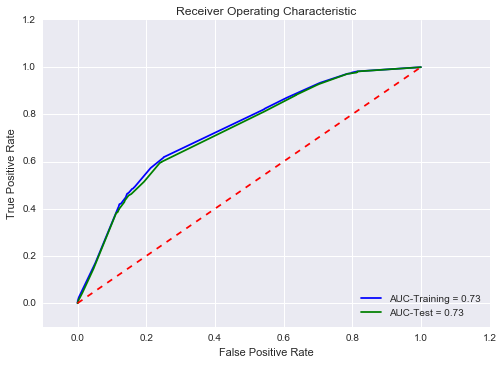

In [154]:
# Plot the actual ROC curve -
# Plot the curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_train, true_positive_train, 'b',
label='AUC-Training = %0.2f'% roc_auc_train)
plt.plot(false_positive_test, true_positive_test, 'g',
label='AUC-Test = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()